In [203]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier


#Import libraries:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import metrics   #Additional scklearn functions
from sklearn.model_selection import GridSearchCV   #Perforing grid search

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

In [204]:
# preprocessing 

train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
submission=pd.read_csv('sample_submission.csv')

prepros=train.copy()
prepros.drop(['gender'],inplace=True,axis=1)
prepros=prepros.append(test, ignore_index=True)   # dataframe containing test and train


In [205]:
 train['gender'] = LabelEncoder().fit_transform(train['gender'])

In [206]:
ProductList_processed=[]
ProductList_processed_bask_no=[]
ProductList_processed_no=[]
for i in range(prepros.shape[0]):
    ProductList_processed.append((prepros['ProductList'][i].strip().replace(';','').replace('/',' ')))
    ProductList_processed_no.append(len(prepros['ProductList'][i].strip().replace(';','').replace('/',' ')))
    ProductList_processed_bask_no.append(len(list(prepros['ProductList'][i].split(';'))))

In [207]:
prepros['ProductList_processed']=ProductList_processed
prepros['ProductList_processed_bask_no']=ProductList_processed_bask_no
prepros['ProductList_processed_no']=ProductList_processed_no

In [208]:
corpus=ProductList_processed
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)
cols=vectorizer.get_feature_names()

In [209]:
X_m=X.toarray()
prod2vec=pd.DataFrame(data=X_m,
          index=np.array(range(15000)),
          columns=cols)

In [210]:
svd = TruncatedSVD(n_components=50, n_iter=7, random_state=42)

svd.fit(X)

X_tr=svd.fit_transform(X)

#X_embedded=TSNE(n_components=2).fit_transform(X_tr)

In [211]:
#plt.scatter(X_embedded[:,0],X_embedded[:,1])

In [212]:
prod2vec_red=pd.DataFrame(data=X_tr,
          index=np.array(range(15000)),
          columns=np.array(range(50)))

In [213]:
prepros=pd.concat([prepros, prod2vec_red], axis=1, sort=False)
prepros_p2v=prepros.copy()

In [214]:
prepros_p2v.drop(['ProductList','ProductList_processed'],inplace=True,axis=1)

In [215]:
prepros_p2v['startTime']=pd.to_datetime(prepros_p2v['startTime'])
prepros_p2v['endTime']=pd.to_datetime(prepros_p2v['endTime'])

In [216]:
prepros_p2v['duration']=(prepros_p2v['endTime']-prepros_p2v['startTime']).astype('timedelta64[m]')

In [217]:
prepros_p2v['hour']=prepros_p2v['startTime'].dt.hour

In [218]:
prepros_p2v['weekday']=(prepros_p2v['startTime'].dt.weekday_name).astype('category')

In [219]:
prepros_p2v['day']=prepros_p2v['startTime'].dt.day

In [220]:
prepros_p2v['month']=prepros_p2v['startTime'].dt.month

In [307]:
prepros_p2v['weekday'] = LabelEncoder().fit_transform(prepros_p2v['weekday'])

In [308]:
prepros_p2v_f=prepros_p2v.drop(['startTime','endTime'], axis=1)

In [309]:
####training and test split####

pro_train=prepros_p2v_f[:train.shape[0]]

In [310]:
pro_test=prepros_p2v_f[train.shape[0]:]

In [311]:
pro_test=pro_test.drop(['session_id'],axis=1)
pro_train=pro_train.drop(['session_id'],axis=1)

In [312]:
X_train, X_test, y_train, y_test = train_test_split(pro_train, 
                                                    train['gender'], 
                                                    test_size=0.15, 
                                                    random_state=8)

In [291]:
# # xgb=XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=6,
#  min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
#  objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27)

# xgb.fit(pro_train, train['gender'])
for i in [180,190,200,210,220,230]:
    clf = XGBClassifier( learning_rate =0.1, n_estimators=i, max_depth=7,
 min_child_weight=5, gamma=.106, subsample=0.9, colsample_bytree=0.9,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27)

    eval_set  = [(X_train, y_train),(X_test, y_test)]

    clf.fit(X_train, y_train,
            eval_set=eval_set, eval_metric='error',verbose=0)

    pred = clf.predict_proba(X_test)[:,1]
    accuracy = accuracy_score(y_test, np.round(pred))
    print( "SCORE:", accuracy)
    prep_sub(clf)

SCORE: 0.8717460317460317
SCORE: 0.8717460317460317
SCORE: 0.873015873015873
SCORE: 0.873015873015873
SCORE: 0.873015873015873
SCORE: 0.873015873015873
SCORE: 0.8704761904761905
SCORE: 0.8704761904761905
SCORE: 0.8717460317460317
SCORE: 0.8717460317460317
SCORE: 0.8698412698412699
SCORE: 0.8698412698412699


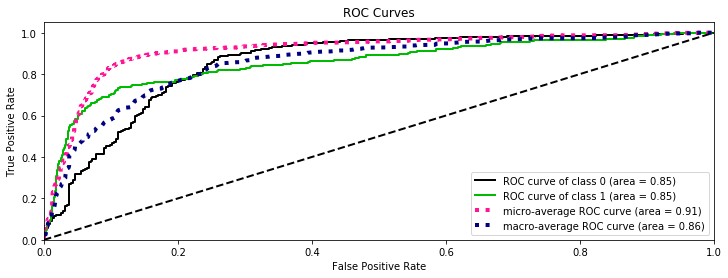

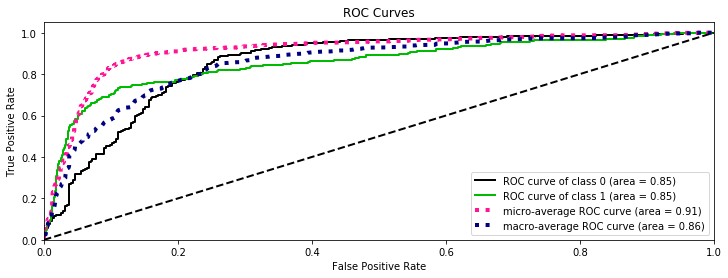

In [269]:
import scikitplot as skplt
import matplotlib.pyplot as plt
# ground truth labels
y_probas = clf.predict_proba(X_test)# predicted probabilities generated by sklearn classifier
skplt.metrics.plot_roc_curve(y_test, y_probas)
plt.show()

In [267]:
np.array(y_test)


array([0, 0, 0, ..., 0, 0, 0])

array([0, 0, 0, ..., 0, 0, 0])

In [260]:
pip install scikit-plot

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [104]:
def prep_sub(clf):
    pred = clf.predict(pro_test)
    Pred=pd.DataFrame(pred)
    mapping = {0: 'female', 1: 'male'}
    Pred=Pred.replace({0: mapping, 1: mapping})
    submission['gender']=Pred[0]
    submission.to_csv('submission.csv',index=False)

In [126]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}

gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=166, max_depth=5,
min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27),
                        
param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=3)
gsearch1.fit(pro_train,train['gender'])
gsearch1.best_params_, gsearch1.best_score_

//anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
//anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'max_depth': 5, 'min_child_weight': 1}, 0.8443009485694576)

({'max_depth': 5, 'min_child_weight': 1}, 0.8443009485694576)

In [127]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=166, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=3)
gsearch3.fit(pro_train,train['gender'])
gsearch3.best_params_, gsearch3.best_score_

//anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
//anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'gamma': 0.1}, 0.8444350146241476)

({'gamma': 0.1}, 0.8444350146241476)

In [128]:
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=3, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=train['gender'])
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], train['gender'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(train['gender'].values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(train['gender'], dtrain_predprob))
                    
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



Model Report
Accuracy : 0.9121
AUC Score (Train): 0.958083

Model Report
Accuracy : 0.9121
AUC Score (Train): 0.958083


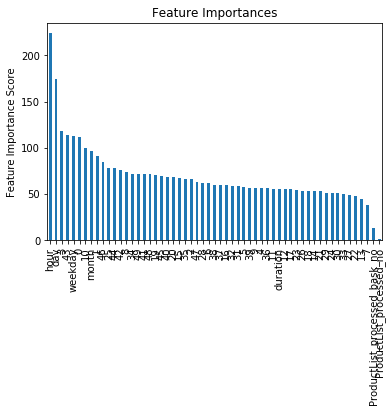

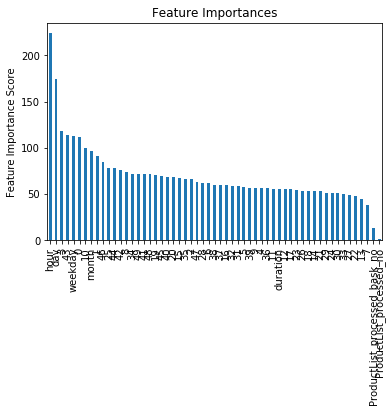

In [129]:
xgb2 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=166,
 max_depth=5,
 min_child_weight=1,
 gamma=0.1,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

predictors = [x for x in pro_train.columns]

modelfit(xgb2, pro_train, predictors)

In [130]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=166, max_depth=5,
 min_child_weight=1, gamma=0.1, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=3)

gsearch4.fit(pro_train,train['gender'])

gsearch4.best_params_, gsearch4.best_score_

//anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
//anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'colsample_bytree': 0.6, 'subsample': 0.9}, 0.8466893746136906)

({'colsample_bytree': 0.6, 'subsample': 0.9}, 0.8466893746136906)

In [131]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=166, max_depth=5,
 min_child_weight=1, gamma=0.1, subsample=0.9, colsample_bytree=0.6,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=3)

gsearch6.fit(pro_train,train['gender'])
gsearch6.best_params_, gsearch6.best_score_

//anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
//anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'reg_alpha': 1e-05}, 0.8466892158940377)

({'reg_alpha': 1e-05}, 0.8466892158940377)

In [464]:
#### stacking trials #####

rf=RandomForestClassifier()

clf_rf=rf.fit(pro_train,train['gender'])

lr=LogisticRegression()

clf_lr=lr.fit(pro_train,train['gender'])

lgb=LGBMClassifier()

clf_lgb=lgb.fit(pro_train,train['gender'])

//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [305]:
def prep_en_sub(clf_l):
    pred=[]
    for clf in clf_l:
        pred.append(np.round(clf.predict(pro_test)))
    Pred=pd.DataFrame(pred).T
    Pred_en=pd.DataFrame(Pred.mode(axis=1)[0])
    mapping = {0: 'female', 1: 'male'}
    Pred_en=pd.DataFrame(Pred_en.replace({0: mapping, 1: mapping}))
    submission['gender']=Pred_en
    print(submission.head())
    submission.to_csv('submission.csv',index=False)

In [287]:
clf_l=[clf,clf_lr,clf_rf,clf_lgb]

prep_en_sub(clf_l)

  session_id  gender
0     u12112  female
1     u19725  female
2     u11795  female
3     u22639  female
4     u18034  female
  session_id  gender
0     u12112  female
1     u19725  female
2     u11795  female
3     u22639  female
4     u18034  female


In [289]:
lgb=LGBMClassifier()

clf_lgb=lgb.fit(pro_train,train['gender'])

prep_sub(clf_lgb)


In [291]:
pro_train.shape

(10500, 106)

(10500, 106)

In [331]:
import pandas as pd 
import matplotlib.pyplot as plt

import os
import keras

import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor

seed = 7

np.random.seed(seed)

max_features = 5000
maxlen = 400
batch_size = 32
embedding_dims = 50
filters = 100
kernel_size = 3
hidden_dims = 100
epochs = 2

# Model
model = Sequential()
model.add(Dense(100, input_dim=57, kernel_initializer='normal', activation='relu'))
model.add(Dense(hidden_dims, kernel_initializer='normal', activation='softplus'))
model.add(Dense(hidden_dims, kernel_initializer='normal', activation='softplus'))
model.add(Dense(1, kernel_initializer='normal',activation='sigmoid'))
# Compile model
model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.RMSprop(lr=.0001),metrics=['accuracy'])

feature_cols = pro_train
labels = train['gender']

history = model.fit(np.array(feature_cols), np.array(labels),validation_split=.1, epochs=30,batch_size=20)

Train on 9450 samples, validate on 1050 samples
Train on 9450 samples, validate on 1050 samples
Epoch 1/30
Epoch 1/30
9450/9450 [==============================] - 1s 149us/step - loss: 2.3696 - accuracy: 0.7668 - val_loss: 0.5706 - val_accuracy: 0.7857
Epoch 2/30
9450/9450 [==============================] - 1s 114us/step - loss: 1.1855 - accuracy: 0.7793 - val_loss: 0.5704 - val_accuracy: 0.7857
Epoch 3/30
9450/9450 [==============================] - 1s 113us/step - loss: 0.6630 - accuracy: 0.7822 - val_loss: 0.5169 - val_accuracy: 0.7886
Epoch 4/30
9450/9450 [==============================] - 1s 117us/step - loss: 0.6870 - accuracy: 0.7966 - val_loss: 0.4992 - val_accuracy: 0.8029
Epoch 5/30
9450/9450 [==============================] - 1s 124us/step - loss: 0.7287 - accuracy: 0.8177 - val_loss: 0.4422 - val_accuracy: 0.8210
Epoch 6/30
9450/9450 [==============================] - 1s 130us/step - loss: 0.6401 - accuracy: 0.8272 - val_loss: 0.5547 - val_accuracy: 0.8362
Epoch 7/30
Epoch 

9450/9450 [==============================] - 1s 111us/step - loss: 0.5262 - accuracy: 0.8689 - val_loss: 0.4595 - val_accuracy: 0.8629
Epoch 24/30
9450/9450 [==============================] - 1s 114us/step - loss: 0.4903 - accuracy: 0.8699 - val_loss: 0.3817 - val_accuracy: 0.8695
Epoch 25/30
9450/9450 [==============================] - 1s 116us/step - loss: 0.4584 - accuracy: 0.8704 - val_loss: 0.3819 - val_accuracy: 0.8648
Epoch 26/30
9450/9450 [==============================] - 1s 113us/step - loss: 0.4548 - accuracy: 0.8694 - val_loss: 0.5577 - val_accuracy: 0.8638
Epoch 27/30
Epoch 27/30
9450/9450 [==============================] - 1s 117us/step - loss: 0.4842 - accuracy: 0.8701 - val_loss: 0.5130 - val_accuracy: 0.8610
Epoch 28/30
9450/9450 [==============================] - 1s 117us/step - loss: 0.4704 - accuracy: 0.8697 - val_loss: 0.3778 - val_accuracy: 0.8657
Epoch 29/30
9450/9450 [==============================] - 1s 114us/step - loss: 0.4632 - accuracy: 0.8693 - val_loss: 1

In [332]:
history = model.fit(np.array(feature_cols), np.array(labels),validation_split=.1, epochs=30,batch_size=10)

Train on 9450 samples, validate on 1050 samples
Epoch 1/30
  10/9450 [..............................] - ETA: 4s - loss: 0.0960 - accuracy: 1.0000Train on 9450 samples, validate on 1050 samples
Epoch 1/30
9450/9450 [==============================] - 2s 218us/step - loss: 0.8301 - accuracy: 0.8703 - val_loss: 0.4032 - val_accuracy: 0.8667
Epoch 2/30
9450/9450 [==============================] - 2s 214us/step - loss: 0.4948 - accuracy: 0.8692 - val_loss: 3.5935 - val_accuracy: 0.8648
Epoch 3/30
9450/9450 [==============================] - 2s 215us/step - loss: 0.5511 - accuracy: 0.8698 - val_loss: 0.4727 - val_accuracy: 0.8648
Epoch 4/30
9450/9450 [==============================] - 2s 217us/step - loss: 0.5566 - accuracy: 0.8698 - val_loss: 0.4716 - val_accuracy: 0.8667
Epoch 5/30
9450/9450 [==============================] - 2s 248us/step - loss: 0.6863 - accuracy: 0.8702 - val_loss: 0.3937 - val_accuracy: 0.8667
Epoch 6/30
9450/9450 [==============================] - 2s 230us/step - loss:

KeyboardInterrupt: 

KeyboardInterrupt: 

In [333]:
prep_subd( model)

In [319]:
def prep_subd(clf):
    pred = clf.predict(pro_test)
    Pred=pd.DataFrame(np.round(pred))
    mapping = {0: 'female', 1: 'male'}
    Pred=Pred.replace({0: mapping, 1: mapping})
    submission['gender']=Pred[0]
    submission.to_csv('submission.csv',index=False)

In [465]:
clf_l=[clf,clf_lr,clf_rf,clf_lgb,model]

prep_en_sub(clf_l)

  session_id  gender
0     u12112  female
1     u19725  female
2     u11795  female
3     u22639  female
4     u18034  female
  session_id  gender
0     u12112  female
1     u19725  female
2     u11795  female
3     u22639  female
4     u18034  female


In [494]:
clf = XGBClassifier( learning_rate =0.1, n_estimators=135, max_depth=7,
 min_child_weight=5, gamma=0, subsample=0.9, colsample_bytree=0.9,
 objective= 'binary:logistic', nthread=4,reg_alpha=0.01, scale_pos_weight=1,seed=27)

eval_set  = [(X_train, y_train),(X_test, y_test)]

clf.fit(X_train, y_train,
            eval_set=eval_set, eval_metric='error')

pred = clf.predict_proba(X_test)[:,1]
accuracy = accuracy_score(y_test, np.round(pred))
print("SCORE:", accuracy)

[0]	validation_0-error:0.125266	validation_1-error:0.145397
[0]	validation_0-error:0.125266	validation_1-error:0.145397
[1]	validation_0-error:0.121345	validation_1-error:0.137143
[1]	validation_0-error:0.121345	validation_1-error:0.137143
[2]	validation_0-error:0.122017	validation_1-error:0.137143
[2]	validation_0-error:0.122017	validation_1-error:0.137143
[3]	validation_0-error:0.121345	validation_1-error:0.136508
[3]	validation_0-error:0.121345	validation_1-error:0.136508
[4]	validation_0-error:0.121008	validation_1-error:0.137778
[4]	validation_0-error:0.121008	validation_1-error:0.137778
[5]	validation_0-error:0.121345	validation_1-error:0.135873
[5]	validation_0-error:0.121345	validation_1-error:0.135873
[6]	validation_0-error:0.120448	validation_1-error:0.135873
[6]	validation_0-error:0.120448	validation_1-error:0.135873
[7]	validation_0-error:0.121232	validation_1-error:0.135873
[7]	validation_0-error:0.121232	validation_1-error:0.135873
[8]	validation_0-error:0.120896	validati

[67]	validation_0-error:0.099608	validation_1-error:0.130794
[68]	validation_0-error:0.099496	validation_1-error:0.130794
[68]	validation_0-error:0.099496	validation_1-error:0.130794
[69]	validation_0-error:0.099608	validation_1-error:0.132063
[69]	validation_0-error:0.099608	validation_1-error:0.132063
[70]	validation_0-error:0.099496	validation_1-error:0.131429
[70]	validation_0-error:0.099496	validation_1-error:0.131429
[71]	validation_0-error:0.098936	validation_1-error:0.130794
[71]	validation_0-error:0.098936	validation_1-error:0.130794
[72]	validation_0-error:0.098375	validation_1-error:0.130794
[72]	validation_0-error:0.098375	validation_1-error:0.130794
[73]	validation_0-error:0.097815	validation_1-error:0.131429
[73]	validation_0-error:0.097815	validation_1-error:0.131429
[74]	validation_0-error:0.098263	validation_1-error:0.131429
[74]	validation_0-error:0.098263	validation_1-error:0.131429
[75]	validation_0-error:0.097031	validation_1-error:0.130794
[75]	validation_0-error:

[134]	validation_0-error:0.076863	validation_1-error:0.127619
SCORE: 0.8723809523809524
SCORE: 0.8723809523809524


In [495]:
prep_sub(clf)

In [125]:
### hp tuning RF ##

## logistic regr ##
from sklearn.pipeline import Pipeline

#pipe = Pipeline([('classifier' , LogisticRegression())])
pipe = Pipeline([('classifier', RandomForestClassifier())])

# Create param grid.

param_grid = [
    #{'classifier' : [LogisticRegression()],
   #  'classifier__penalty' : ['l1', 'l2'],
   # 'classifier__C' : np.logspace(-4, 4, 20),
    #'classifier__solver' : ['liblinear']},
    {'classifier' : [RandomForestClassifier()],
    'classifier__n_estimators' : list(range(10,101,10)),
    'classifier__max_features' : list(range(6,32,5))}
]

# Create grid search object

clf = GridSearchCV(pipe, param_grid = param_grid, cv = 3, verbose=True, n_jobs=-1)

# Fit on data

best_clf = clf.fit(pro_train, train['gender'])

Fitting 3 folds for each of 60 candidates, totalling 180 fits
Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  6.8min finished
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  6.8min finished


In [510]:
prep_sub(best_clf)

In [198]:
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

X, y = pro_train,train['gender']


estimators = [
             ('rf', RandomForestClassifier(n_estimators=10, random_state=42)),
             #('svr', make_pipeline(StandardScaler(),
                          # LinearSVC(penalty='l2',random_state=42,max_iter=10000))),
             ('lr', LogisticRegression(solver='liblinear',penalty='l1')),
             ('knn', make_pipeline(StandardScaler(),
                           KNeighborsClassifier())),
             ('nb', make_pipeline(StandardScaler(),
                           GaussianNB()))
             #('lr', LogisticRegression(penalty='l2'))
 ]

clf = StackingClassifier(
    estimators=estimators, n_jobs=-1,passthrough=True,verbose = 1,final_estimator= XGBClassifier(learning_rate =0.1, n_estimators=166, max_depth=5,
 min_child_weight=1, gamma=0.1, subsample=0.9, colsample_bytree=0.6,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27))

from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(
     X, y, stratify=y, random_state=42,test_size =.1
 )


clf.fit(X_train, y_train).score(X_test, y_test)


0.8733333333333333

0.8733333333333333

In [199]:
prep_sub(clf)

In [197]:
for clf=LogisticRegression(solver='liblinear',penalty='l1')
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

0.8507936507936508
0.8507936507936508


In [ ]:
from sklearn.svm import SVC


scaler = StandardScaler()
print(scaler.fit(pro_train))
protrain1=pd.DataFrame(scaler.transform((pro_train)))

X_train, X_test, y_train, y_test = train_test_split(
     protrain1, train['gender'], stratify=y, random_state=42,test_size =.2
 )

for i in [.001,.01,.1,1,10,100,1000]:
    clf=SVC(kernel='linear',C=i,verbose=0,gamma='auto')
    clf.fit(X_train, y_train)
    print(clf.score(X_test, y_test))